# Hotkeys  
- `A`, `B` front and back
- `ESC`, `ENTER` writing or commands
- `M`, `Y` md and code 


# Start

In [344]:
#r "nuget:Microsoft.Data.Analysis"
#r "nuget:ScottPlot"

using System;
using System.Reflection;

using Microsoft.DotNet.Interactive.Formatting;

using Microsoft.Data.Analysis;

using Newtonsoft.Json;

bool DEBUG = true;

Installed Packages Microsoft.Data.Analysis, 0.21.1 ScottPlot, 5.0.36

In [345]:
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);

class PlotBuilder {
    ScottPlot.Plot plot;

    public PlotBuilder (string title = "") {
        plot = new ();
        plot.Axes.Title.Label.Text = title;
    }

    public PlotBuilder Add<T1, T2> (List<T1> x, List<T2> y, string legend = default) {
        plot.Add.Scatter(x, y).LegendText = legend ?? "";
        return this;
    }
    public PlotBuilder Add<T> (List<T> y, string legend = default) => Add(Enumerable.Range(0, y.Count).ToList(), y, legend);
    public PlotBuilder Add<T> (List<(T,T)> y, (string, string) legend = default) =>
        Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2);
    public PlotBuilder Add<T> (List<(T,T,T)> y, (string, string, string) legend = default) => 
         Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2)
        .Add(y.Select(y => y.Item3).ToList(), legend.Item3);

    public PlotBuilder LimitY(double y0, double y1) {
        plot.Axes.SetLimitsY(y0, y1);
        return this;
    } 
    public PlotBuilder Limit(double x0, double x1, double y0, double y1) {
        plot.Axes.SetLimits(x0, x1, y0, y1);
        return this;
    }
    public PlotBuilder LimitH(double h) => LimitY(0, h); 

    public ScottPlot.Plot Build ()  {  
        plot.Axes.SetLimits(0, 1000);
        return plot; 
    }
}


In [371]:
static DataFrame CreateDataFrame<T> (List<T> objects, bool getProperties = true) {
    Type type = typeof(T);
    BindingFlags flags = BindingFlags.Public | BindingFlags.Instance;
    FieldInfo[] fields = type.GetFields(flags);
    List<(string, Type)> names = fields.Select(f => (f.Name, f.FieldType)).ToList();
    List<List<object>> boxed = objects.Select(item => fields.Select(f => f.GetValue(item)).ToList()).ToList();

    if (getProperties) {
        PropertyInfo[] properties = type.GetProperties(flags);
        names.AddRange(properties.Select(f => (f.Name, f.PropertyType)).ToList());
        boxed.AddRange(objects.Select(item => properties.Select(f => f.GetValue(item)).ToList()));
    }
    names.Log();
    "Hej med dig".Log();
    return DataFrame.LoadFrom(boxed, names);
}

static DataFrame CreateDataFrame<T> (params T[] objects) => CreateDataFrame(objects.ToList());
static DataFrame ToDataFrame<T>(this List<T> objects) => CreateDataFrame(objects); 
static DataFrame ToDataFrame<T>(this T item) => CreateDataFrame(item); 
static DataFrame Concat(this DataFrame df, DataFrame added, string prefix = "" ) => new DataFrame(df.Columns.Concat(added.Clone().AddPrefix(prefix).Columns));

In [372]:
static string DumpS(this object value) => value is not string ? JsonConvert.SerializeObject(value, Formatting.None) : value as string;

static T[] DumpMulti<T> (this T[] values) {
    values.ToList().ForEach(item => item.Dump());
    return values;  
} 
static IEnumerable<T> DumpMulti<T> (this IEnumerable<T> values) {
    values.ToList().ForEach(item => item.Dump());
    return values;
} 
static T Dump<T>(this T value) => DumpOneLine(value);

static T DumpOneLine<T> (this T value) {
    Console.WriteLine(value.DumpS());
    return value;
}
static void Log(this object item) => Console.WriteLine(item);


In [373]:
Random random = new Random(29);

float NextGauss (float mean, float stdDev) {
    float u1 = 1.0f - random.NextSingle();
    float u2 = 1.0f - random.NextSingle();
    float randStdNormal = (float)Math.Sqrt(-2.0f * Math.Log(u1)) * (float)Math.Sin(2.0f * Math.PI * u2); 
    float randNormal = mean + stdDev * randStdNormal; 
    return randNormal;
}
float NextGauss (float mu, float sigma, float min, float max) {
    float x;
    do
    {
        x = NextGauss(mu, sigma);
    } while (x < min || x > max);

    return x;
}

# Simulation

In [374]:
public partial struct Market
{
    public uint Food, Oxygen, Minerals, Water;
}

public partial struct MarketF
{
    public float Food, Oxygen, Minerals, Water;
}


public struct Population
{
    public uint Farmers, Laborers, Engineers;
    public uint Children;
    public uint Total => Farmers + Laborers;
    //public float FarmersNeed, LaborersNeed, EngineersNeed;
}

public struct Points 
{
    public int Value;
}

In [375]:
public partial struct Market
{
    public uint Food, Oxygen, Minerals, Water;
}

public partial struct MarketF
{
    public float Food, Oxygen, Minerals, Water;
}


public struct Population
{
    public uint Farmers, Laborers, Engineers;
    public uint Children;
    //public float FarmersNeed, LaborersNeed, EngineersNeed;
}

public struct Points 
{
    public int Value;
}

In [376]:
static Market sub(Market a, Market b) => new Market
    {
        Food     = a.Food     - b.Food,
        Oxygen   = a.Oxygen   - b.Oxygen,
        Minerals = a.Minerals - b.Minerals,
        Water    = a.Water    - b.Water
    };
static MarketF divF(Market a, Market b) => new MarketF
    {
        Food     = (float) a.Food     / b.Food,
        Oxygen   = (float) a.Oxygen   / b.Oxygen,
        Minerals = (float) a.Minerals / b.Minerals,
        Water    = (float) a.Water    / b.Water
    };
static Market min (Market a, Market b) => new Market
    {
        Food     = Math.Min(a.Food,     b.Food),
        Oxygen   = Math.Min(a.Oxygen,   b.Oxygen),
        Minerals = Math.Min(a.Minerals, b.Minerals),
        Water    = Math.Min(a.Water,    b.Water)
    };
static uint sum (this Population a) => a.Farmers + a.Laborers + a.Engineers + a.Children; 

In [377]:
void Build(in Population population, out Market market)
{
    market.Food = population.Farmers* 5;
    market.Minerals = population.Laborers;
    market.Oxygen = population.Engineers * 100;
    market.Water = population.Engineers * 20;
}

In [378]:
void Births (float deathRate, ref Population population) {
    float decrease = Math.Clamp(1 - deathRate, 0.8f, 1);
    float increase = 0.02f;//Math.Clamp(NextGauss(0.0002f, 0.0001f), 0, 0.01f);

    population.Children = (uint) (population.sum() * increase);

    population.Farmers   = (uint)(population.Farmers   * decrease);
    population.Laborers  = (uint)(population.Laborers  * decrease);
    population.Engineers = (uint)(population.Engineers * decrease);
} 

In [379]:
void Promote (in MarketF ratios, ref Population population) {
    // demand
    if (ratios.Oxygen < 1.2 || ratios.Water < 1.2) {
        uint p = (uint) (population.Farmers * 0.1f);
        population.Farmers -= p;
        population.Engineers += p;
    }

    // children
    if (ratios.Oxygen < 1 || ratios.Water < 1)
        population.Engineers += population.Children;
    else if (ratios.Food < 1)
        population.Farmers += population.Children;
    else
        population.Laborers += population.Children;
}

In [380]:
void Consume(in Market market, ref Population population, out MarketF ratio, out Market surplus)
{
    uint pops = population.sum();
    
    Market need = new();
    need.Oxygen = pops * 2;
    need.Food   = pops;
    need.Water  = pops;

    Market bought = min(market, need);

    surplus = sub(market, bought);

    ratio = divF(bought, need);
}


In [382]:
Market market;
Market surplus;
MarketF ratio;
Population population = new Population { Engineers = 10, Farmers = 10, Laborers = 1000 };

void SimulateStep () {
    Build(in population, out market);
    Consume(in market, ref population, out ratio, out surplus);
    Promote(in ratio, ref population);
    Births(1 - ratio.Oxygen, ref population);
}

// log
List<Population> populations = new (), populationsDecline = new ();
List<Market> markets = new (), surpluses = new (), marketsDecline = new ();

for (int i = 0; i < 1000; i++) {
    uint populationSum = population.sum();
    
    SimulateStep();

    surpluses.Add(surplus);
    markets.Add(market);
    populations.Add(population);
    if (population.sum() >= populationSum)
        continue;

    populationsDecline.Add(population);
    marketsDecline.Add(market);
    $"Population Shrinking from [{populationSum:E1} to {population.sum():E1}], POP {populationSum:E1}, children {population.Children:E1}, O2 {ratio.Oxygen:0.00}".Dump();//*/
}
new object[] {$"Simulation Completed with {populationsDecline.Count} declines", population, market}.DumpOneLine();

Population Shrinking from [1.0E+003 to 8.4E+002], POP 1.0E+003, children 2.0E+001, O2 0.49
Population Shrinking from [8.4E+002 to 6.8E+002], POP 8.4E+002, children 1.7E+001, O2 0.48
Population Shrinking from [5.4E+007 to 4.4E+007], POP 5.4E+007, children 1.1E+006, O2 0.80
Population Shrinking from [5.3E+007 to 4.3E+007], POP 5.3E+007, children 1.1E+006, O2 0.39
Population Shrinking from [5.3E+007 to 4.4E+007], POP 5.3E+007, children 1.1E+006, O2 0.59
Population Shrinking from [5.3E+007 to 4.4E+007], POP 5.3E+007, children 1.1E+006, O2 0.76
Population Shrinking from [5.3E+007 to 4.3E+007], POP 5.3E+007, children 1.1E+006, O2 0.14
Population Shrinking from [5.3E+007 to 4.3E+007], POP 5.3E+007, children 1.1E+006, O2 0.28
Population Shrinking from [5.3E+007 to 4.3E+007], POP 5.3E+007, children 1.1E+006, O2 0.44
Population Shrinking from [5.3E+007 to 4.4E+007], POP 5.3E+007, children 1.1E+006, O2 0.61
Population Shrinking from [5.3E+007 to 4.4E+007], POP 5.3E+007, children 1.1E+006, O2 0.77


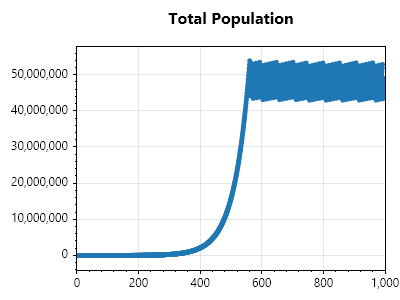

In [381]:
new PlotBuilder("Total Population").Add(populations.Select(pop => pop.sum()).ToList()).Build()


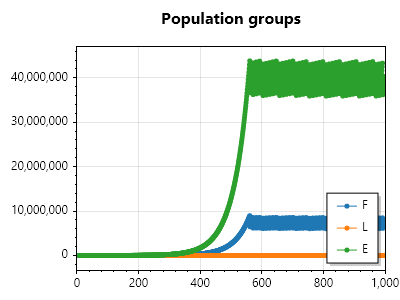

In [383]:
new PlotBuilder("Population groups").Add(populations.Select(pop => (pop.Farmers, pop.Laborers, pop.Engineers)).ToList(), ("F", "L", "E")).Build()


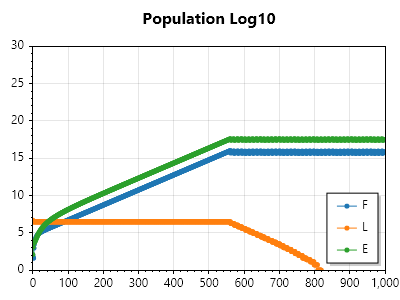

In [384]:
new PlotBuilder("Population Log10").Add(populations.Select(pop => (Math.Log(pop.Farmers), Math.Log(pop.Laborers), Math.Log(pop.Engineers))).ToList(), ("F", "L", "E")).LimitH(30).Build()

In [385]:
market.ToDataFrame()

index,Food,Oxygen,Minerals,Water
0,37281560,3953867600,0,790773520


In [389]:
var pop = populations.ToDataFrame();
var mrk = markets.ToDataFrame();
var srp = surpluses.ToDataFrame().AddPrefix("d");

pop.Concat(mrk).Concat(srp)

index,Farmers,Laborers,Engineers,Children,Food,Oxygen,Minerals,Water,dFood,dOxygen,dMinerals,dWater
0,7,800,8,20,50,1000,1000,200,0,0,1000,0
1,5,640,22,17,35,800,800,160,0,0,800,0
2,5,640,39,14,25,2200,640,440,0,832,640,0
3,19,640,39,14,25,3900,640,780,0,2504,640,82
4,32,640,40,14,95,3900,640,780,0,2476,640,68
5,43,640,43,14,160,4000,640,800,0,2548,640,74
6,53,640,47,15,215,4300,640,860,0,2820,640,120
7,63,640,52,15,265,4700,640,940,0,3190,640,185
8,72,640,58,15,315,5200,640,1040,0,3660,640,270
9,80,640,65,16,360,5800,640,1160,0,4230,640,375
